In [1]:
from pyralysis.transformers import UVTaper
from pyralysis.io import DaskMS
from pyralysis.reconstruction import Image
import dask
import dask.array as da
import astropy.units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.constants import c
import xarray as xr
from pyralysis.units import lambdas_equivalencies
from pyralysis.transformers.weighting_schemes import Uniform, Robust
from pyralysis.transformers import Gridder, HermitianSymmetry, DirtyMapper, UVTaper
from pyralysis.units import array_unit_conversion
from pyralysis.io import FITS, HDF5
from pyralysis.convolution import PSWF1
from astropy.units import Quantity
from daskms import xds_from_table
import traceback
import warnings
import sys

In [2]:
def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file, 'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

In [3]:
warnings.showwarning = warn_with_traceback

In [4]:
#x = DaskMS(input_name="/home/miguel/Documents/pyralysis/datasets/antennae/all_fields.ms")
#x = DaskMS(input_name="/home/miguel/Documents/datasets/belen/9.8-9.5.ms", chunks={"row": 100000})
#x = DaskMS(
#    input_name="/home/miguel/Documents/datasets/ALMA/HD135344B/calibrated_cont_self.ms",
#    chunks={
#        "row": 100000,
#        "chan": 1
#    }
#)
x = DaskMS(input_name="/home/miguel/Downloads/RT124_sim739.ms")
#x = DaskMS(
#    input_name="/home/miguel/Documents/datasets/ALMA/HTLup_continuum.ms", chunks={"row": 100000}
#)
#x = DaskMS(input_name="/home/miguel.carcamo/B4/residual.ms")

In [5]:
dataset = x.read(filter_flag_column=False, calculate_psf=False)

In [6]:
l = dataset.field.phase_direction_cosines[0]
m = dataset.field.phase_direction_cosines[1]

Text(0.5, 1.0, 'Pointings in deg')

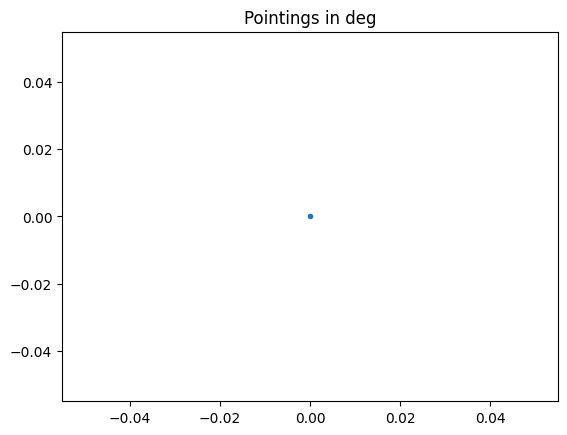

In [7]:
plt.plot(l.to(u.deg), m.to(u.deg), '.')
plt.title("Pointings in {0}".format(u.deg))

In [8]:
hermitian_symmetry = False
padding_factor = 1.2

In [9]:
if hermitian_symmetry:
    h_symmetry = HermitianSymmetry(input_data=dataset)
    h_symmetry.apply()

In [10]:
imsize = 512

In [11]:
dx = dataset.theo_resolution / 7
#dx = 0.01 * u.arcsec

In [12]:
dx

<Quantity 2.17841632e-08 rad>

Text(0.5, 1.0, 'Pointings in pixels')

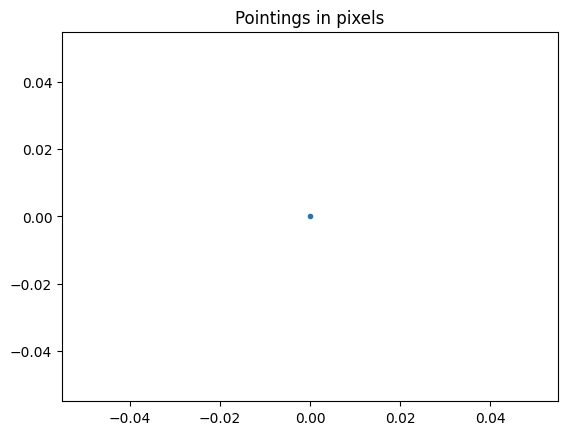

In [13]:
plt.plot(l / dx, m / dx, '.')
plt.title("Pointings in pixels")

Text(0.5, 1.0, 'Pointings in pixels shifted to 256')

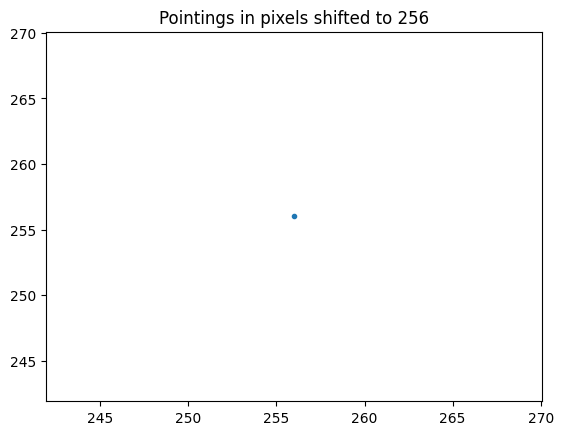

In [14]:
plt.plot(l / dx + imsize // 2, m / dx + imsize // 2, '.')
plt.title("Pointings in pixels shifted to {0}".format(imsize // 2))

In [15]:
pb = dataset.antenna.primary_beam

In [16]:
pb.cellsize = dx
chans = dataset.spws.dataset[0].CHAN_FREQ.data.squeeze(axis=0)

In [17]:
centers_l = (l / (-dx) + imsize // 2).astype(np.int32)
centers_m = (m / dx + imsize // 2).astype(np.int32)

In [18]:
p_beams = da.array(
    [
        pb.beam(
            chans, (imsize, imsize), antenna=np.array([0]), imcenter=(centers_l[i], centers_m[i])
        ) for i in range(centers_l.size)
    ]
)

In [19]:
p_beams_together = da.sum(p_beams, axis=(0, 1, 2))

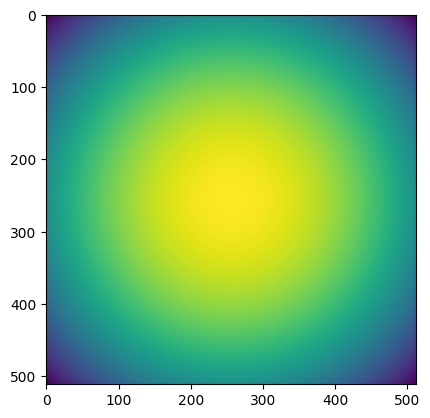

In [20]:
plt.imshow(p_beams_together)

In [21]:
gridder = Gridder(
    imsize=imsize,
    cellsize=dx,
    hermitian_symmetry=hermitian_symmetry,
    padding_factor=padding_factor
)

In [22]:
fits_io = FITS()

In [23]:
robust_param = -1.

In [24]:
#uniform = Uniform(input_data=dataset, gridder=gridder)
robust = Robust(input_data=dataset, robust_parameter=robust_param, gridder=gridder)

In [25]:
#uniform.apply()
robust.apply()

In [26]:
#ckernel = None
ckernel = PSWF1(size=3, cellsize=dx, oversampling_factor=3)

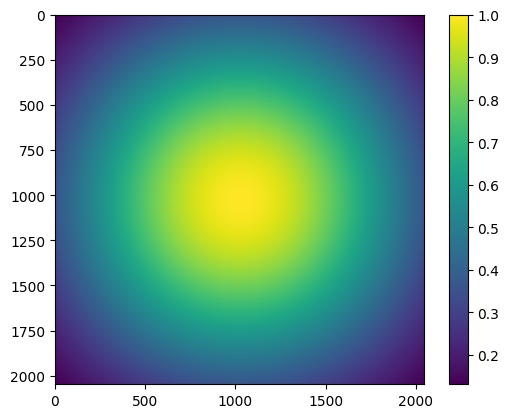

In [27]:
if ckernel is not None:
    plt.imshow(ckernel.gcf((2048, 2048)).real)
    plt.colorbar()

In [28]:
dirty_mapper = DirtyMapper(
    input_data=dataset,
    imsize=imsize,
    cellsize=dx,
    stokes=["I"],
    hermitian_symmetry=hermitian_symmetry,
    padding_factor=padding_factor,
    ckernel_object=ckernel
)

In [29]:
dirty_mapper.cellsize

<Quantity [-2.17841632e-08,  2.17841632e-08] rad>

In [30]:
dirty_images_robust = dirty_mapper.transform()

In [31]:
dirty_image, dirty_beam = dask.compute(
    *[dirty_images_robust[0].data[0], dirty_images_robust[1].data[0]]
)

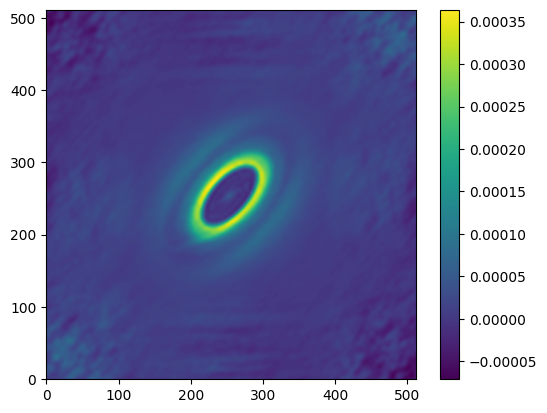

In [32]:
plt.imshow(dirty_image, origin="lower", vmin=np.min(dirty_image), vmax=np.max(dirty_image))
#plt.xlim([800,1200])
#plt.ylim([800, 1200])
plt.colorbar()

In [33]:
np.std(dirty_image), np.min(dirty_image), np.max(dirty_image)

(<xarray.DataArray 'divide-e8aafb4593b8bc2f4b0224bc1c02074a' ()>
 array(4.0577233e-05, dtype=float32),
 <xarray.DataArray 'divide-e8aafb4593b8bc2f4b0224bc1c02074a' ()>
 array(-7.137871e-05, dtype=float32),
 <xarray.DataArray 'divide-e8aafb4593b8bc2f4b0224bc1c02074a' ()>
 array(0.00036413, dtype=float32))

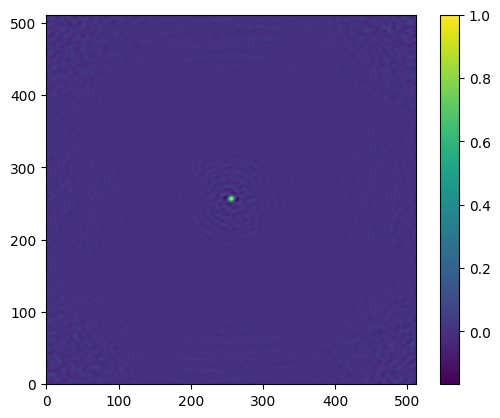

In [34]:
plt.imshow(dirty_beam, origin="lower", vmin=np.min(dirty_beam), vmax=np.max(dirty_beam))
#plt.xlim([800,1200])
#plt.ylim([800, 1200])
plt.colorbar()

In [35]:
fits_io.write(dirty_image, output_name="dirty_images_robust_uniform.fits")
fits_io.write(dirty_beam, output_name="dirty_beam_robust_uniform.fits")

In [36]:
#fits_io.write(dirty_image, output_name="dirty_images_robust_"+str(robust_param)+".fits")
#fits_io.write(dirty_beam, output_name="dirty_beam_robust_"+str(robust_param)+".fits")

In [37]:
gridded_visibilities, gridded_weights = da.compute(
    *[dirty_mapper.uvgridded_visibilities, dirty_mapper.uvgridded_weights]
)

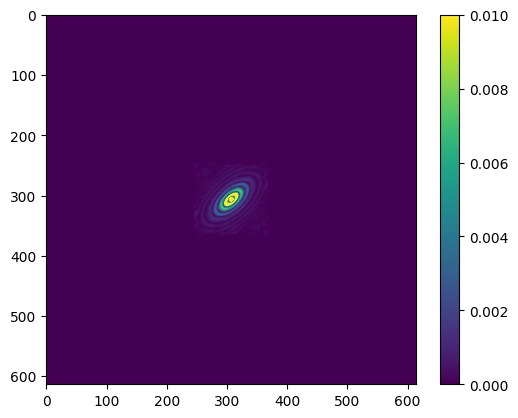

In [38]:
plt.imshow(np.abs(gridded_visibilities[0]), vmax=0.01)
plt.colorbar()
#plt.xlim([400, 200])
#plt.ylim([200, 400])

In [39]:
np.unravel_index(np.argmax(np.abs(gridded_visibilities[0])), gridded_visibilities[0].shape)

(307, 307)

In [40]:
gridded_weights[0].shape

(614, 614)

In [41]:
fits_io.write(gridded_weights[0], output_name="dirty_images_weights.fits")

In [42]:
weight = dataset.ms_list[0].visibilities.weight.compute()

In [43]:
weight

<xarray.DataArray 'WEIGHT' (row: 239295, corr: 2)>
array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)
Coordinates:
    ROWID    (row) int64 0 1 2 3 4 5 ... 239144 239153 239160 239169 239198
Dimensions without coordinates: row, corr

In [44]:
u.arcmin.find_equivalent_units()

Primary name | Unit definition | Aliases  
[
  arcmin       | 0.000290888 rad | arcminute ,
  arcsec       | 4.84814e-06 rad | arcsecond ,
  cycle        | 6.28319 rad     | cy        ,
  deg          | 0.0174533 rad   | degree    ,
  hourangle    | 0.261799 rad    |           ,
  mas          | 4.84814e-09 rad |           ,
  rad          | irreducible     | radian    ,
  uas          | 4.84814e-12 rad |           ,
]

In [45]:
im = Image(data=xr.DataArray(np.zeros((256, 256))), cellsize=0.003 * u.arcsec, name="I")

In [46]:
im.pixel_area

<Quantity 2.11539875e-16 sr>

In [47]:
#im.calculate_noise(dataset)

In [48]:
noise = im.noise
noise

In [49]:
# x.write(dataset, "alfredo.ms", ["CORRECTED_DATA", "WEIGHT"])